In [176]:
import os
import numpy as np
import nibabel as nib
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import preprocess_input, InceptionV3
from keras.utils import to_categorical
import matplotlib
import matplotlib.pyplot as plt
from scipy.misc import imresize, imrotate
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from keras import models

%matplotlib inline


In [2]:
def preprocess_data_coronal(X,target_height=299,target_width=299, base_slice=64,rescale=False,):
    '''Convert each MR volume to three slices through a single plane, scales the data and resamples
    to 299 by 299 pixels. Optionally performs augmentation.'''   
    #slices = [22,36,50] #Planes to slice
    slices = np.array([base_slice,base_slice,base_slice]) #Planes to slice
    pad_max = np.max([X.shape[1],X.shape[3]]) #Width to pad images to
    
    num_volumes = X.shape[0]
    height = X.shape[1]
    width = X.shape[3]
    num_slices = X.shape[2]
    X_preprocessed = np.zeros((num_volumes,target_height,target_width,3))

    for i in range(num_volumes):
        for j in range(3):
            if (j == 0):
                X_preprocessed[i,:,:,j] = imresize(pad_image(np.squeeze(X[i,:,slices[j],:]),pad_max),(target_width,target_height))
            if (j == 1):
                X_preprocessed[i,:,:,j] = imresize(pad_image(np.squeeze(X[i,:,slices[j],:]),pad_max),(target_width,target_height))
            if (j == 2):
                X_preprocessed[i,:,:,j] = imresize(pad_image(np.squeeze(X[i,:,slices[j],:]),pad_max),(target_width,target_height))     
   
    if rescale == True:
        X_preprocessed = X_preprocessed.astype(np.float32)
        X_preprocessed/= 255
        X_preprocessed -= 0.5
        X_preprocessed *= 2.
    return X_preprocessed

def preprocess_data_saggital(X,target_height=299,target_width=299, base_slice=64,rescale=False,):
    '''Convert each MR volume to three slices through a single plane, scales the data and resamples
    to 299 by 299 pixels. Optionally performs augmentation.'''   
    #slices = [22,36,50] #Planes to slice
    slices = np.array([base_slice,base_slice,base_slice]) #Planes to slice
    pad_max = np.max([X.shape[1],X.shape[3]]) #Width to pad images to
    
    num_volumes = X.shape[0]
    height = X.shape[1]
    width = X.shape[2]
    num_slices = X.shape[3]
    X_preprocessed = np.zeros((num_volumes,target_height,target_width,3))

    for i in range(num_volumes):
        for j in range(3):
            if (j == 0):
                X_preprocessed[i,:,:,j] = imresize(pad_image(np.squeeze(X[i,slices[j],:,:]),pad_max),(target_width,target_height))
            if (j == 1):
                X_preprocessed[i,:,:,j] = imresize(pad_image(np.squeeze(X[i,slices[j],:,:]),pad_max),(target_width,target_height))
            if (j == 2):
                X_preprocessed[i,:,:,j] = imresize(pad_image(np.squeeze(X[i,slices[j],:,:]),pad_max),(target_width,target_height))     
   
    if rescale == True:
        X_preprocessed = X_preprocessed.astype(np.float32)
        X_preprocessed/= 255
        X_preprocessed -= 0.5
        X_preprocessed *= 2.
    return X_preprocessed

def pad_image(image,pad_max):
    if pad_max == 0:
        return image
    else:
        pad_width = np.array([[pad_max,pad_max],[pad_max,pad_max]])-[image.shape,image.shape]
        pad_width=np.transpose(pad_width)
        pad_width[:,0] = np.floor(pad_width[:,0]/2)
        pad_width[:,1] = np.ceil(pad_width[:,1]/2)
        return np.lib.pad(image,pad_width,'constant',constant_values=(0))
    
def fetch_real_data(base_dir,num_subjects):
    '''Load in simulated data and motion files.'''
    subject_list = os.listdir((os.path.join(base_dir)))
    subject_list = [item for item in subject_list if item.startswith('sub') == True] #Filter everything but subjects
    subject_list = sorted(subject_list) #sort in numerical order to make OS independent
    print(subject_list)
    counter = 0
    num_vols=172
    X = np.zeros((num_vols*num_subjects,128,128,64))
    y = np.zeros(num_vols*num_subjects)
    X_subject = np.zeros((128,128,64,num_vols))
    y_subject = np.zeros(num_vols)
    for subject_index, subject_number in enumerate(subject_list):
        if subject_index < num_subjects:
            data_path = os.path.join(base_dir,subject_number,'dwi.nii.gz')
            if os.path.isfile(data_path):
                data_header = nib.load(data_path)
                X_subject = data_header.get_data()
                y_subject = np.load(os.path.join(base_dir,subject_number,'y_manual.npy'))
                start_index = counter*num_vols
                end_index = (counter+1)*num_vols
                X[start_index:end_index,:] = np.moveaxis(X_subject,3,0)
                y[start_index:end_index] = y_subject
                counter += 1
    return X,y

In [3]:
#Load in real DWI data
# X_header = nib.load('../data/real/dwi/dwi.nii.gz')
# X = X_header.get_data()
# X = np.moveaxis(X,3,0)

X_full,y_full = fetch_real_data('../data/sourcedata/',10)
X=X_full[1204:,:,:,:]
y=y_full[1204:]

del X_full,y_full

print(X.shape,y.shape)

['sub-CC00069XX12', 'sub-CC00099AN18', 'sub-CC00117XX10', 'sub-CC00122XX07', 'sub-CC00126XX11', 'sub-CC00138XX15', 'sub-CC00162XX06', 'sub-CC00164XX08', 'sub-CC00168XX12', 'sub-CC00170XX06']
(516, 128, 128, 64) (516,)


2.0


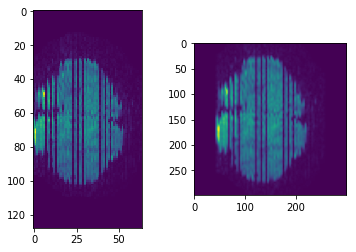

In [147]:
slice_=30
X_test = preprocess_data_coronal(X[:,20:110,:,:],base_slice=slice_)

pos_indices = np.where(y!=0)[0]
index=41
index2 = pos_indices[index]

plt.subplot(1,2,1)
plt.imshow(X[index2,:,slice_,:])
plt.subplot(1,2,2)
plt.imshow(X_test[index2,:,:,0])
print(y[index2])

In [240]:
from sklearn.metrics import confusion_matrix, accuracy_score
from keras import models
#from sklearn.model_selection import accuracy

model_coronal =   models.load_model('keras_logs/2017-10-09-15-06-43.epoch29-lossval0.19.hdf5')
model_saggital=   models.load_model('keras_logs/2017-10-09-13-45-17.epoch29-lossval0.20.hdf5')

validation_generator = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-6,
    rotation_range=0.,
    width_shift_range=0.,
    height_shift_range=0.,
    shear_range=0.0,
    zoom_range=0.,
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=None,
    preprocessing_function=preprocess_input,
    data_format='channels_last',)

num_slices = 30
validation_batch_size = 43
num_validation_steps = X_test.shape[0]/validation_batch_size
model_predictions_coronal = np.zeros((X_test.shape[0],num_slices))
#model_predictions_saggital = np.zeros((X_test.shape[0],num_slices))
y_test_fake = np.ones((X_test.shape[0]))

for i in range(num_slices):
    #Coronal
    X_test_slice = preprocess_data_coronal(X[:,20:110,:,:],base_slice = 20+2*i)  
    #Redefine validation generator to reset
    validation_data_for_testing = validation_generator.flow(X_test_slice,y_test_fake,batch_size=validation_batch_size,shuffle=False)
    model_predictions_coronal[:,i] = model_coronal.predict_generator(validation_data_for_testing,num_validation_steps)[:,1]
    
#     #saggital
#     X_test_slice = preprocess_data_saggital(X,base_slice = 35+2*i)  
#     #Redefine validation generator to reset
#     validation_data_for_testing = validation_generator.flow(X_test_slice,y_test_fake,batch_size=validation_batch_size,shuffle=False)
#     model_predictions_saggital[:,i] = model_saggital.predict_generator(validation_data_for_testing,num_validation_steps)[:,1]

    print('Slices complete:',i)

Slices complete: 0
Slices complete: 1
Slices complete: 2
Slices complete: 3
Slices complete: 4
Slices complete: 5
Slices complete: 6
Slices complete: 7
Slices complete: 8
Slices complete: 9
Slices complete: 10
Slices complete: 11
Slices complete: 12
Slices complete: 13
Slices complete: 14
Slices complete: 15
Slices complete: 16
Slices complete: 17
Slices complete: 18
Slices complete: 19
Slices complete: 20
Slices complete: 21
Slices complete: 22
Slices complete: 23
Slices complete: 24
Slices complete: 25
Slices complete: 26
Slices complete: 27
Slices complete: 28
Slices complete: 29


0.0


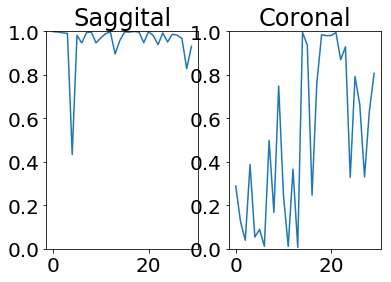

In [308]:
#pos_indices = np.where(y==0)[0]
pos_indices = ind_false_pos
index=24
index2 = pos_indices[index]
plt.subplot(1,2,1)
plt.plot(model_predictions_saggital[index2,:])
plt.ylim(0,1)
plt.title('Saggital')

plt.subplot(1,2,2)
plt.plot(model_predictions_coronal[index2,:])
plt.ylim(0,1)
plt.title('Coronal')

print(y[index2])
# y_pred_coronal = (np.sum(model_predictions_coronal>0.5,axis=1) > 1)
# y_pred_saggital = (np.sum(model_predictions_saggital>0.5,axis=1) > 3)



# np.save('misc_files/predictions_combined_real_data',predictions_combined)



In [320]:
#from sklearn.externals import joblib
#svm_classifier = joblib.load('misc_files/svm_classifier.pkl') 
#rf_classifier = joblib.load('misc_files/rf_classifier.pkl') 

#y_pred_svm = svm_classifier.predict(predictions_combined) 
#y_pred_rf = rf_classifier.predict(predictions_combined) 
#predictions_combined = np.concatenate((model_predictions_coronal,model_predictions_saggital),axis=1)
predictions_combined = model_predictions_saggital

y_pred = np.mean(predictions_combined,axis=1) > 0.9
y_pred *= np.mean(model_predictions_coronal,axis=1) > 0.7

#y = np.load('../data/real/dwi/y_manual.npy')

print(y.shape)
print(classification_report((y!=0),y_pred))
print(confusion_matrix((y!=0),y_pred))

(516,)
             precision    recall  f1-score   support

      False       0.97      0.97      0.97       438
       True       0.82      0.83      0.83        78

avg / total       0.95      0.95      0.95       516

[[424  14]
 [ 13  65]]


## Visualise

In [194]:
from sklearn.metrics import accuracy_score, confusion_matrix
from matplotlib import animation
from matplotlib import animation, rc
from IPython.display import HTML

y_val = (y!=0)
y_pred_val = y_pred
ind_true_pos = [indx for indx,y in enumerate(y_val) if (y_val[indx] == 1) and (y_pred_val[indx] == 1) ]
ind_true_neg = [indx for indx,y in enumerate(y_val) if (y_val[indx] == 0) and (y_pred_val[indx] == 0) ]
ind_false_neg = [indx for indx,y in enumerate(y_val) if (y_val[indx] == 1) and (y_pred_val[indx] == 0) ]
ind_false_pos = [indx for indx,y in enumerate(y_val) if (y_val[indx] == 0) and (y_pred_val[indx] == 1) ]

In [189]:
#Animated plot of confusion-matrix
#X, y = fetch_data(os.path.join(root_dir,'data/sims'),8)
X_test_preprocessed = preprocess_data_saggital(X)
#del X, y

X_test_preprocessed_plot = X_test_preprocessed.astype(np.float32)/255
#X_test_preprocessed_plot += 0.5

fig=plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

image1 = ax1.imshow(np.zeros((X_test_preprocessed_plot.shape[1],X_test_preprocessed_plot.shape[2],3))); ax1.axis('off')
image2 = ax2.imshow(np.zeros((X_test_preprocessed_plot.shape[1],X_test_preprocessed_plot.shape[2],3))); ax2.axis('off')
image3 = ax3.imshow(np.zeros((X_test_preprocessed_plot.shape[1],X_test_preprocessed_plot.shape[2],3))); ax3.axis('off')
image4 = ax4.imshow(np.zeros((X_test_preprocessed_plot.shape[1],X_test_preprocessed_plot.shape[2],3))); ax4.axis('off')
fig.text(0.5, 0.94, 'Predictions', ha='center',weight='bold')
fig.text(0.06, 0.5, 'Actual', ha='center',weight='bold')
fig.text(0.08, 0.7, 'False', ha='center')
fig.text(0.08, 0.3, 'True', ha='center')
fig.text(0.32, 0.9, 'False', ha='center')
fig.text(0.7, 0.9, 'True', ha='center')
fig.text(0.47, 0.52, str(len(ind_true_neg)), ha='center',color='white')
fig.text(0.55, 0.52, str(len(ind_false_pos)), ha='center',color='white')
fig.text(0.47, 0.45, str(len(ind_false_neg)), ha='center',color='white')
fig.text(0.55, 0.45, str(len(ind_true_pos)), ha='center',color='white')

matplotlib.rcParams.update({'font.size': 20})
fig.subplots_adjust(hspace=0.03, wspace=0.02)
plt.close()

def init():
    image1.set_data(np.zeros((X_test_preprocessed_plot.shape[1],X_test_preprocessed_plot.shape[2]))); 
    image2.set_data(np.zeros((X_test_preprocessed_plot.shape[1],X_test_preprocessed_plot.shape[2])))
    image3.set_data(np.zeros((X_test_preprocessed_plot.shape[1],X_test_preprocessed_plot.shape[2])))
    image4.set_data(np.zeros((X_test_preprocessed_plot.shape[1],X_test_preprocessed_plot.shape[2])))
    
    return image1,image2,image3,image4,

def animate(i):
    image1.set_data(np.rot90(X_test_preprocessed_plot[ind_true_neg[i % len(ind_true_neg)],:]))
    image2.set_data(np.rot90(X_test_preprocessed_plot[ind_false_pos[i % len(ind_false_pos)],:]))
    image3.set_data(np.rot90(X_test_preprocessed_plot[ind_false_neg[i % len(ind_false_neg)],:]))
    image4.set_data(np.rot90(X_test_preprocessed_plot[ind_true_pos[i % len(ind_true_pos)],:]))
    return image1,image2,image3,image4,

anim = animation.FuncAnimation(fig,animate,init_func=init,frames=40,interval=200,blit=True)
mywriter = animation.FFMpegWriter()
HTML(anim.to_html5_video())

KeyError: 'ffmpeg'

2.0


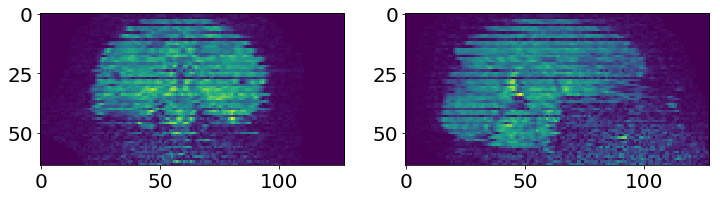

In [239]:
plt.figure(figsize=(12,12))
index =9
slice_=64
index2 = ind_false_neg[index]
plt.subplot(1,2,1)
plt.imshow(np.rot90(X[index2,:,slice_,:]))
plt.subplot(1,2,2)
plt.imshow(np.rot90(X[index2,slice_,:,:]))
print(y[index2])